In [2]:
#Import the Libraries
import numpy as np
from scipy.io import loadmat  # this is the SciPy module that loads mat-files
import matplotlib.pyplot as plt
from datetime import datetime, date, time
import pandas as pd
import os
from natsort import natsorted
import re

## MATLAB to BIDS

In [3]:
#Make a list of the files
Mat_Beh_dir='data'
ML_EvFiles_list=natsorted([os.path.join(root,f) for root,dirs,files in os.walk(
    Mat_Beh_dir) for f in files if 'run' in f])
print("The number of Subjects are: %s"%(len([x for x in os.listdir(Mat_Beh_dir) if x.startswith('sub')])))
print("The number of files are: %s"%(len(ML_EvFiles_list)))
print("----------------------------------------")
#Make Conditions for Run1 and Run2
run_cond=loadmat('timing/run1.mat')
run1=run_cond['run']['cond'][0,0]
run1 = np.where(run1==[1], 'Large_gain', run1)
run1 = np.where(run1==['2'], 'Large_loss', run1)
run1 = np.where(run1==['3'], 'Small_gain', run1)
run1 = np.where(run1==['4'], 'Small_loss', run1)
run1 = np.where(run1==['5'], 'Neutral', run1)
run1=np.concatenate(run1)

run_cond=loadmat('timing/run2.mat')
run2=run_cond['run']['cond'][0,0]
run2 = np.where(run2==[1], 'Large_gain', run2)
run2 = np.where(run2==['2'], 'Large_loss', run2)
run2 = np.where(run2==['3'], 'Small_gain', run2)
run2 = np.where(run2==['4'], 'Small_loss', run2)
run2 = np.where(run2==['5'], 'Neutral', run2)
run2=np.concatenate(run2)

#Load the .mat convert to dataframe add trial_type and detect bad data
for ML_EvFile in ML_EvFiles_list:
    sub='sub-'+re.search('sub-(.*)/',ML_EvFile).group(1)
    run='run-'+re.search('run-(.*)_out',ML_EvFile).group(1)
    mat = loadmat(ML_EvFile)  # load mat-file
    mdata = mat['output']  # variable in mat file
    mdtype = mdata.dtype  # dtypes of structures are "unsized objects"
    # * SciiencPy reads in structures as structured NumPy arrays of dtype object
    # * The size of the array is the size of the structure array, not the number
    #   elements in any particular field. The shape defaults to 2-dimensional.
    # * For convene make a dictionary of the data using the names from dtypes
    # * Since the structure has only one element, but is 2-D, index it at [0, 0]
    ndata = {n: mdata[n][0, 0] for n in mdtype.names}
    # Reconstruct the columns of the data table from just the time series
    # Use the number of intervals to test if a field is a column or metadata
    columns = [n for n in ndata]
    #Check fo frame
    # now make a data frame, setting the time stamps as the index
    lens=[len(x[0]) for x in ndata.values()]
    if lens.count(lens[0]) == len(lens):
        df = pd.DataFrame(np.transpose(np.concatenate([ndata[c] for c in columns])),
                  columns=columns)
        if run=='run-1':
            if len(df)==50:
                df['trial_type']=run1[0:50]
            elif len(df)==75:
                df['trial_type']=run1
        if run=='run-2':
            df['trial_type']=run2
        os.makedirs('bids/%s'%(sub),exist_ok=True) 
        df.to_csv('bids/%s/%s_task-MID_%s_events.tsv'%(sub,sub,run),sep = '\t', index=False)
    else:
        
        print("Problem with %s %s"%(sub,run))

The number of Subjects are: 48
The number of files are: 64
----------------------------------------
Problem with sub-1253 run-1
Problem with sub-3101 run-1
Problem with sub-3122 run-1


## Import BIDS data


In [4]:
Mat_Beh_dir='bids'
EvFiles_list=natsorted([os.path.join(root,f) for root,dirs,files in os.walk(
    Mat_Beh_dir) for f in files if 'run' in f])
df_list=[]
for file in EvFiles_list:
    sub='sub-'+re.search('sub-(.*)/',file).group(1)
    run='run-'+re.search('run-(.*)_even',file).group(1)
    temp_df=pd.read_csv(file,sep='\t')
    temp_df['sub']=sub
    temp_df['run']=run
    df_list.append(temp_df)
DF=pd.concat(df_list)

print("Subjects with NaN data:%s"%(DF[DF.isna().any(axis=1)]['sub'].unique()))
DF=DF.dropna()
print("The Number of Subjects retained is: %s "%(len(DF['sub'].unique())))
DF=DF.reset_index()

Subjects with NaN data:['sub-999']
The Number of Subjects retained is: 39 


,sub,trial_type,index,trial_starts,target_starts,RT,thresh,outcome,Log_RT
0,sub-1007,Large_gain,23.45,216.396944,219.357145,0.330519,0.407718,0.70,0.574908
1,sub-1007,Large_loss,23.50,214.234758,217.344892,0.308454,0.430307,0.70,0.555386
3,sub-1007,Small_gain,28.15,256.833365,259.793253,0.361322,0.392951,0.65,0.601101
4,sub-1007,Small_loss,22.80,208.707708,211.617775,0.384829,0.423703,0.50,0.620346
5,sub-1009,Large_gain,23.45,216.397933,219.357990,0.266897,0.366865,0.85,0.516621


<AxesSubplot:xlabel='trial_type', ylabel='outcome'>

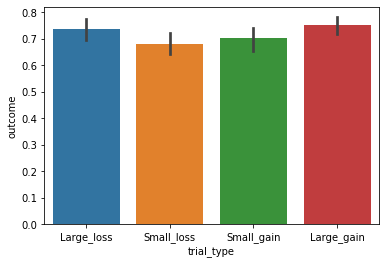

In [25]:
import seaborn as sms
DF_by=DF.groupby(by=['sub','trial_type']).mean().reset_index()
DF_by['Log_RT']=DF_by['RT'].transform(func=np.sqrt)
DF_by=DF_by[DF_by['trial_type']!='Neutral']
display(DF_by.head())
sms.barplot(data=DF_by,x='trial_type',y='outcome',
            order=['Large_loss','Small_loss','Small_gain','Large_gain'])

<AxesSubplot:xlabel='trial_type', ylabel='RT'>

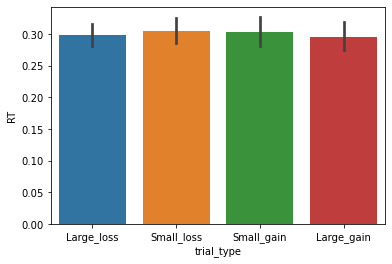

In [27]:
sms.barplot(data=DF_by,x='trial_type',y='RT',
            order=['Large_loss','Small_loss','Small_gain','Large_gain'])

<AxesSubplot:xlabel='trial_type', ylabel='thresh'>

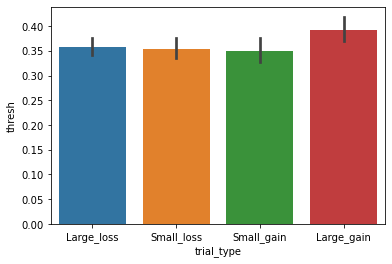

In [29]:
sms.barplot(data=DF_by,x='trial_type',y='thresh',
            order=['Large_loss','Small_loss','Small_gain','Large_gain'])